# Graphing Subreddits

This notebook explores some basic concepts of graph theory. A few weeks ago I set up a script to scrape data from [reddit.com](reddit.com) with the goal of visualizing the network of related subreddits (forums on specific topics) and related data. 

Reddit is home over 600,000 communities, known as subreddits, where people come to share information, opinions, links, etc. and discuss things in a open forum. Most subreddits display links to related subreddits. For example, /r/apple (the Apple subreddit) links to /r/iPhone, a subreddit all about the iPhone, and over a dozen other Apple-related subreddits. 

If you visit reddit.com as a guest, you will see a list of popular subreddits. This list is located inside an `html` tag called `drop-choices`. Here it is:

In [ ]:
from selenium import webdriver
import re
import time
import numpy as np
from bs4 import BeautifulSoup

driver = webdriver.PhantomJS()
driver.get('https://www.reddit.com/')
time.sleep(4 + np.random.random())
html = driver.page_source.encode('utf-8')

s = BeautifulSoup(html)
defaults = s.find('div', attrs={'class':'drop-choices'})
subs = re.compile(r"\/r\/[\w.]+\/?")
default_subreddits = list(set(subs.findall(str(defaults))))

for x in default_subreddits: print '[' + x + '](https://reddit.com'+ x + '), ',

Here are the elements of `default_subreddits`:

> 
[/r/LifeProTips/](https://reddit.com/r/LifeProTips/),  [/r/Futurology/](https://reddit.com/r/Futurology/),  [/r/OldSchoolCool/](https://reddit.com/r/OldSchoolCool/),  [/r/mildlyinteresting/](https://reddit.com/r/mildlyinteresting/),  [/r/askscience/](https://reddit.com/r/askscience/),  [/r/UpliftingNews/](https://reddit.com/r/UpliftingNews/),  [/r/aww/](https://reddit.com/r/aww/),  [/r/GetMotivated/](https://reddit.com/r/GetMotivated/),  [/r/personalfinance/](https://reddit.com/r/personalfinance/),  [/r/gadgets/](https://reddit.com/r/gadgets/),  [/r/science/](https://reddit.com/r/science/),  [/r/dataisbeautiful/](https://reddit.com/r/dataisbeautiful/),  [/r/DIY/](https://reddit.com/r/DIY/),  [/r/AskReddit/](https://reddit.com/r/AskReddit/),  [/r/space/](https://reddit.com/r/space/),  [/r/nosleep/](https://reddit.com/r/nosleep/),  [/r/Documentaries/](https://reddit.com/r/Documentaries/),  [/r/todayilearned/](https://reddit.com/r/todayilearned/),  [/r/television/](https://reddit.com/r/television/),  [/r/IAmA/](https://reddit.com/r/IAmA/),  [/r/Art/](https://reddit.com/r/Art/),  [/r/EarthPorn/](https://reddit.com/r/EarthPorn/),  [/r/books/](https://reddit.com/r/books/),  [/r/gifs/](https://reddit.com/r/gifs/),  [/r/Showerthoughts/](https://reddit.com/r/Showerthoughts/),  [/r/blog/](https://reddit.com/r/blog/),  [/r/news/](https://reddit.com/r/news/),  [/r/Jokes/](https://reddit.com/r/Jokes/),  [/r/TwoXChromosomes/](https://reddit.com/r/TwoXChromosomes/),  [/r/videos/](https://reddit.com/r/videos/),  [/r/philosophy/](https://reddit.com/r/philosophy/),  [/r/nottheonion/](https://reddit.com/r/nottheonion/),  [/r/explainlikeimfive/](https://reddit.com/r/explainlikeimfive/),  [/r/movies/](https://reddit.com/r/movies/),  [/r/Music/](https://reddit.com/r/Music/),  [/r/WritingPrompts/](https://reddit.com/r/WritingPrompts/),  [/r/worldnews/](https://reddit.com/r/worldnews/),  [/r/pics/](https://reddit.com/r/pics/),  [/r/history/](https://reddit.com/r/history/),  [/r/listentothis/](https://reddit.com/r/listentothis/),  [/r/sports/](https://reddit.com/r/sports/),  [/r/food/](https://reddit.com/r/food/),  [/r/creepy/](https://reddit.com/r/creepy/),  [/r/announcements/](https://reddit.com/r/announcements/),  [/r/gaming/](https://reddit.com/r/gaming/),  [/r/tifu/](https://reddit.com/r/tifu/),  [/r/funny/](https://reddit.com/r/funny/),  [/r/photoshopbattles/](https://reddit.com/r/photoshopbattles/),  [/r/InternetIsBeautiful/](https://reddit.com/r/InternetIsBeautiful/),  

My goal here is to see how many subreddits we can reach as we branch off of these "default" subreddits into their related subreddits.

First, we need to set up data structures to hold data for subreddits and their related subreddits. And we need to define an algorithm for collecting data. 

Here's an intrdoduction to graphs from [python.org](https://www.python.org/doc/essays/graphs/):

> Few programming languages provide direct support for graphs as a data type, and Python is no exception. However, graphs are easily built out of lists and dictionaries. For instance, here's a simple graph (I can't use drawings in these columns, so I write down the graph's arcs):

>```A -> B
A -> C
B -> C
B -> D
C -> D
D -> C
E -> F
F -> C 
```

This graph has six nodes (A-F) and eight arcs. It can be represented by the following Python data structure:
>```graph =     {'A': ['B', 'C'],
             'B': ['C', 'D'],
             'C': ['D'],
             'D': ['C'],
             'E': ['F'],
             'F': ['C']}```

First let's define how we would go only one branch deep into this graph (i.e. find the related subreddits for *only* the default subreddits). To collect the data, I first looped through the default subreddits and save the html of each subreddit to its own text file. Here's a script with comments: 

In [ ]:
#first we navigate to the correct folder where we will store the first level of related subreddits
os.chdir(os.path.expanduser('~/Documents/Projects/Data/Subreddits/one/'))

#next we instantiate the webdriver we will be using: PhantomJS
driver = webdriver.PhantomJS()

#loop through the list of default subreddits
for num, subreddit in enumerate(default_subreddits):
    
    #for each subreddit, we append the /r/subreddit path to the base URL (reddit.com)
    driver.get('https://www.reddit.com'+subreddit)
    
    #wait for two seconds
    time.sleep(2 + np.random.random())
    
    #save the html of the loaded page to a variable: html
    html = driver.page_source.encode('utf-8')
    
    #remove '/r/' from the subreddit name string
    name = subreddit.split('/')[2]
    
    #open a new file and give it the name of the subreddit we just scraped
    subreddit_html_file = open(name+'.txt', 'w+')
    
    #write the html contents to the file
    subreddit_html_file.write(html)
    
    #clost the file
    subreddit_html_file.close()
    
    #print out the number and name of the subreddit we just scrapped to make sure things are working
    print str(num) + ' ' + subreddit,


Next, we want to go through each file and extract the information we want. Here's what we will be getting:

- Number of subscribers
- Subreddit description
- Date created
- Related subreddits

For this type of project, I prefer to loop through each page and creating several small dictionaries for each data point, then combine the small dictionaries into a large dictionary, and then append the dictionary to a list of dictionaries. Once I have looped through all of the pages, I can create a pandas DataFrame from the list of dictionaries. This allows me to easily manipulate the data. Here's the script that I used to do this:

In [ ]:
#navigate to where the html files are stored (I moved them around a bit so it is not consistent with the script above)
os.chdir('E://DATA/Subreddits/subreddits_html/')

#generate a list of files that we will loop through
files = os.listdir('E://DATA/Subreddits/subreddits_html/')

#set up an empty list that we will append dictionaries to
dict_list = []

#loop through the files
for file_ in files:
    
    #print out the name of the current file in the loop
    print file_,
    
    #open the file
    f = open(file_, 'r')
    #read the file contents to a local variable
    html = f.read()
    #create a BeautifulSoup object that we will use to parse the HTML
    b = BeautifulSoup(html, 'lxml')

    #get the subreddit name that we are working with (from the `file` variable)
    subreddit_name = '/r/' + file_[:-4].lower()
    #put the name into a dictionary
    subreddit_name_dict = {'subreddit':subreddit_name}
    
    #get number of subscribers
    subs = b.find('span', attrs={'class':'subscribers'})
    #if the number of subscribers is displayed on the page, then we find it and add it to a dictionary
    if subs:
        subs = b.find('span', attrs={'class':'subscribers'}).find('span', attrs={'class':'number'}).text.replace(',', '')
        subs_dict = {'subscribers':int(subs)}
    #if the number of subscribers is not displayed on the page, then we set the number of subscribers in the dictionary to None
    else:
        subs_dict = {'subscribers':None}
    
    #similar process for the description: if the description is displayed, get it and save it to desc
    #if it is not available, then desc will be set to `None`
    desc = b.find('div', attrs={'class':'md'})
    if desc:
        desc = b.find('div', attrs={'class':'md'}).text
        desc = desc.replace('\n', ' ')
    desc_dict = {'description':desc}

    #here we use regular expressions to find links anywhere on the page that have the structure: "/r/something/"
    rel_subr = re.compile(r"\/r\/[\w.]+\/?")
    #make a list of these links based on the "/r/something/" pattern
    related_subreddits = rel_subr.findall(html)
    
    #save the list to a dictionary
    subreddits_dict = {'related':related_subreddits}
    
    #same processes for recording the date that the subreddit was created: get the date from an HTML element, 
    #then save it to a dictionary. There were two different formats available in the HTML so I grabbed both
    age = b.find('span', attrs={'class':'age'})
    if age: 
        time1 = age.find('time')['title']
        time2 = age.find('time')['datetime']
    
    #save the date to a dictionary
    time_dict = {"date1":time1, "date2":time2}

    #take all the dictionaries we just created and put them together into one big dictionary
    dictionary = dict(subs_dict.items()+desc_dict.items()+subreddits_dict.items()+subreddit_name_dict.items()+time_dict.items())

    #append the big dictionary to the list that we defined right before the beginning of the loop
    dict_list.append(dictionary)
    
    #deconstruct the Beautiful Soup object (this can eat up memory very quickly, so it is very important when processing lots of data)
    b.decompose()
    
    #clost the file
    f.close()

Next, let's save the results into a csv file. This let's us load the results quickly without having to scrape everyting again. To do this we can use the pandas library. 

In [39]:
import pandas as pd
df0 = pd.DataFrame(dict_list, index=None)

At this point, we can go through the `related` column in the DataFrame and put together a list of all the related subreddits. With this list, we can simply repeat the process over and over again. However, each time we start with a new list of subreddits, we want to make sure that they have not already been collected. 

Next I will read in one DataFrame that represents related subreddits "three levels deep" relative to the default subreddits. 

**Default --> Related --> Related --> Related**

This DataFrame represents the collection of subreddits from all of these "layers" of the graph. 

In [5]:
import os
os.chdir(os.path.expanduser('~/Documents/Projects/Data/reddit_graph/'))
master_df = pd.read_pickle('master_df.p')

Now we can do a quick visualization of the growth in number of subreddits since the website's start in 2005. 

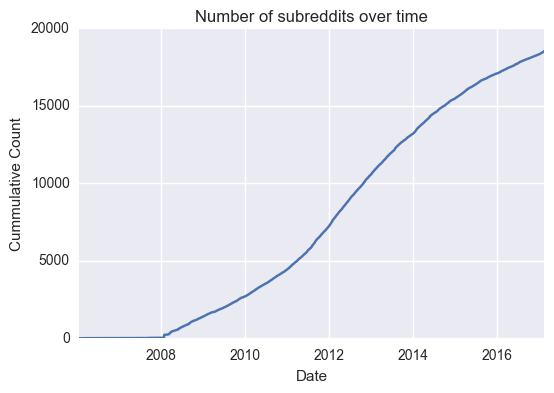

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

master_df_ = master_df[master_df.notnull()]
master_df_.date1 = pd.to_datetime(master_df_['date1'])

list_of_dates = master_df_.date1.sort_values()

counts = np.arange(0, len(list_of_dates))
_ = plt.plot(list_of_dates, counts)
plt.title('Number of subreddits over time')
plt.xlabel('Date')
plt.ylabel('Cummulative Count')

# Setting up a graph with NetworkX

Next we can start to look at the collection of reddits and related subreddits as a graph. I will be using a Python package for network and graph analysis called [NetworkX](https://networkx.github.io). 

In [9]:
#Let's make sure that we have only unique entries in the dataframe.
master_df_u = master_df_.drop_duplicates('subreddit')

In [13]:
master_df_u = master_df_u.drop(master_df_u.index[master_df_u.subreddit=='/r/track__subreddits_'])

In [15]:
#here we define a dictionary where the keys are subreddits and the values are lists of related subreddits
graph = {x:y for x, y in zip(master_df_u.subreddit, master_df_u.related)}

In [16]:
#NetworkX comes with the python Anaconda distribution
import networkx as nx

In [17]:
G=nx.Graph()
G=nx.from_dict_of_lists(graph)
#making the graph undirected takes all of the vertices between nodes and makes them bi-directional
G1 = G.to_undirected()

In [23]:
choice = np.random.choice(master_df_u.subreddit, 2)
print choice

['/r/streetboarding' '/r/stephenking']


Let's test out some of the functions from NetworkX for graph analysis. First, let's take the two randomly selected nodes defined above and test to see if there exists a path between them:

In [27]:
nx.has_path(G1, choice[0], choice[1])

True

# Shortest path

Now let's see (at least one of) the shortest path that exists between these nodes: 

In [29]:
nx.shortest_path(G1, choice[0], choice[1])

['/r/streetboarding',
 '/r/freebord',
 '/r/adrenaline',
 '/r/imaginaryadrenaline',
 '/r/imaginarystephenking',
 '/r/stephenking']

Let's write a function that selects two random subreddits and then prints a shortest path if it exists:

In [30]:
def short_path():
    choices = np.random.choice(master_df_u.subreddit, 2)
    if nx.has_path(G1, choices[0], choices[1]) == True:
        path = nx.shortest_path(G1, choices[0], choices[1])
        print choices[0] + ' and ' + choices[1] + ' are joined by: \n' + str(path)
    else: 
        print "No path exists between " + choices[0] + ' and ' + choices[1]

Here's a collection of results from the `short_path` function defined above that start to paint a picuture of the broad set of topics covered by reddit.com: 

In [41]:
short_path()

/r/personalizationadvice and /r/beautifulfemales are joined by: 
['/r/personalizationadvice', '/r/coloranalysis', '/r/fashion', '/r/redcarpet', '/r/gentlemanboners', '/r/beautifulfemales']


In [42]:
short_path()

/r/caffeine and /r/shittyramen are joined by: 
['/r/caffeine', '/r/toast', '/r/cooking', '/r/ramen', '/r/shittyramen']


In [53]:
short_path()

/r/watchingcongress and /r/iwantthatonashirt are joined by: 
['/r/watchingcongress', '/r/stand', '/r/snowden', '/r/undelete', '/r/trees', '/r/iwantthatonashirt']


In [47]:
short_path()

/r/asksciencediscussion and /r/dogsonhardwoodfloors are joined by: 
['/r/asksciencediscussion', '/r/badscience', '/r/badlinguistics', '/r/animalsbeingjerks', '/r/startledcats', '/r/dogsonhardwoodfloors']


In [63]:
short_path()

/r/randommail and /r/mini are joined by: 
['/r/randommail', '/r/spiceexchange', '/r/cameraswapping', '/r/itookapicture', '/r/carporn', '/r/mini']


In [64]:
short_path()

/r/catsinsinks and /r/nzmovies are joined by: 
['/r/catsinsinks', '/r/wetcats', '/r/tinysubredditoftheday', '/r/sheep', '/r/nzmetahub', '/r/nzmovies']


In [69]:
short_path()

/r/thoriumreactor and /r/sailing are joined by: 
['/r/thoriumreactor', '/r/energy', '/r/spev', '/r/sailing']


In [76]:
short_path()

/r/deathnote and /r/vegetarianism are joined by: 
['/r/deathnote', '/r/television', '/r/netflixbestof', '/r/naturefilms', '/r/environment', '/r/vegetarianism']


In [80]:
short_path()

/r/mississippir4r and /r/mathematics are joined by: 
['/r/mississippir4r', '/r/mississippi', '/r/prisonreform', '/r/socialscience', '/r/alltech', '/r/mathematics']


In [81]:
short_path()

/r/britainsgottalent and /r/irelandbaldwin are joined by: 
['/r/britainsgottalent', '/r/britishtv', '/r/that70sshow', '/r/mila_kunis', '/r/christinaricci', '/r/irelandbaldwin']


In [82]:
short_path()

/r/the_donald and /r/ladybusiness are joined by: 
['/r/the_donald', '/r/shitliberalssay', '/r/trollxchromosomes', '/r/ladybusiness']


In [87]:
short_path()

/r/selfharm and /r/medlabprofessionals are joined by: 
['/r/selfharm', '/r/adhd', '/r/neuroimaging', '/r/pharmacy', '/r/medlabprofessionals']


In [92]:
short_path()

/r/coverart and /r/phillycraftbeer are joined by: 
['/r/coverart', '/r/nostalgia', '/r/upvotedbecausegirl', '/r/wtf', '/r/remindsmeofdf', '/r/beer', '/r/phillycraftbeer']


Let's take a look under the hood of NetworkX and examine the algorith that finds the shortest path between any two subreddits:
```
def shortest_path(G, source=None, target=None, weight=None):
    """Compute shortest paths in the graph.

    Parameters
    ----------
    G : NetworkX graph

    source : node, optional
        Starting node for path.
        If not specified, compute shortest paths using all nodes as source nodes.

    target : node, optional
        Ending node for path.
        If not specified, compute shortest paths using all nodes as target nodes.

    weight : None or string, optional (default = None)
        If None, every edge has weight/distance/cost 1.
        If a string, use this edge attribute as the edge weight.
        Any edge attribute not present defaults to 1.

    Returns
    -------
    path: list or dictionary
        All returned paths include both the source and target in the path.

        If the source and target are both specified, return a single list
        of nodes in a shortest path from the source to the target.

        If only the source is specified, return a dictionary keyed by
        targets with a list of nodes in a shortest path from the source
        to one of the targets.

        If only the target is specified, return a dictionary keyed by
        sources with a list of nodes in a shortest path from one of the
        sources to the target.

        If neither the source nor target are specified return a dictionary
        of dictionaries with path[source][target]=[list of nodes in path].

    Examples
    --------
    >>> G=nx.path_graph(5)
    >>> print(nx.shortest_path(G,source=0,target=4))
    [0, 1, 2, 3, 4]
    >>> p=nx.shortest_path(G,source=0) # target not specified
    >>> p[4]
    [0, 1, 2, 3, 4]
    >>> p=nx.shortest_path(G,target=4) # source not specified
    >>> p[0]
    [0, 1, 2, 3, 4]
    >>> p=nx.shortest_path(G) # source,target not specified
    >>> p[0][4]
    [0, 1, 2, 3, 4]

    Notes
    -----
    There may be more than one shortest path between a source and target.
    This returns only one of them.

    See Also
    --------
    all_pairs_shortest_path()
    all_pairs_dijkstra_path()
    single_source_shortest_path()
    single_source_dijkstra_path()
    """
    if source is None:
        if target is None:
            ## Find paths between all pairs.
            if weight is None:
                paths=nx.all_pairs_shortest_path(G)
            else:
                paths=nx.all_pairs_dijkstra_path(G,weight=weight)
        else:
            ## Find paths from all nodes co-accessible to the target.
            with nx.utils.reversed(G):
                if weight is None:
                    paths=nx.single_source_shortest_path(G, target)
                else:
                    paths=nx.single_source_dijkstra_path(G, target, weight=weight)

                # Now flip the paths so they go from a source to the target.
                for target in paths:
                    paths[target] = list(reversed(paths[target]))

    else:
        if target is None:
            ## Find paths to all nodes accessible from the source.
            if weight is None:
                paths=nx.single_source_shortest_path(G,source)
            else:
                paths=nx.single_source_dijkstra_path(G,source,weight=weight)
        else:
            ## Find shortest source-target path.
            if weight is None:
                paths=nx.bidirectional_shortest_path(G,source,target)
            else:
                paths=nx.dijkstra_path(G,source,target,weight)

    return paths
```

This is a long definition, but when we call the function in the examples above, we include both the source and the target. With these arguments included, we could reduce the above definition to the following: 

```
def shortest_path(G, source=None, target=None, weight=None):
    paths=nx.bidirectional_shortest_path(G,source,target)
    return paths
```

The `bidirectional_shortest_path` function is defined [here](http://networkx.readthedocs.io/en/networkx-1.11/_modules/networkx/algorithms/shortest_paths/unweighted.html?highlight=bidirectional_shortest_path).

Centrality is anohter important topic in graph theory. Here's a brief introduction to centrality from [Wikipedia](https://en.wikipedia.org/wiki/Centrality): 

> In graph theory and network analysis, indicators of centrality identify the most important vertices within a graph. Applications include identifying the most influential person(s) in a social network, key infrastructure nodes in the Internet or urban networks, and super-spreaders of disease.

There are several different methods of measuring centrality in a graph. Here I use `eigenvector_centrality_numpy`, a function included in NetworkX. It takes in a graph and returns a dictionary with graph nodes as keys and node centrality as values. 

In [93]:
centrality = nx.eigenvector_centrality_numpy(G1)

Let's see which subreddit has the highest centrality:

In [117]:
print max(centrality, key=centrality.get), centrality[max(centrality, key=centrality.get)]

/r/imaginarybattlefields 0.0721530261127


In [103]:
len(centrality) == len(sorted(centrality.values(), reverse=True))

True

Since all of the centrality values are unique, we can look up nodes by their centrality values. 

In [112]:
subr_list = []
for node in centrality:
    subr_list.append((node, centrality[node]))
    
sorted_subr_list = subr_list.sort(key=lambda x: x[1])

In [115]:
for x in sorted(subr_list, key=lambda x: x[1], reverse=True)[:200]: print x[0],

/r/imaginarybattlefields /r/imaginarycityscapes /r/imaginarywastelands /r/imaginarywildlands /r/imaginaryleviathans /r/imaginarydragons /r/imaginarystarscapes /r/imaginarywesteros /r/imaginaryartifacts /r/imaginaryangels /r/imaginarymaps /r/imaginarybehemoths /r/imaginarydemons /r/imaginaryelves /r/imaginarycentaurs /r/imaginaryfuturewar /r/imaginarysoldiers /r/imaginaryhistory /r/imaginaryarmor /r/imaginarystarships /r/imaginarynetwork /r/imaginaryjedi /r/imaginarydinosaurs /r/imaginarysteampunk /r/imaginarycyberpunk /r/imaginaryarchers /r/imaginaryvehicles /r/imaginaryanime /r/imaginaryfallout /r/imaginaryastronauts /r/imaginarymusic /r/imaginaryfactories /r/imaginaryequestria /r/imaginarywarships /r/imaginaryazeroth /r/imaginaryarrakis /r/imaginarydisney /r/imaginarypolitics /r/imaginaryhorrors /r/imaginarywinterscapes /r/imaginaryseascapes /r/imaginarypirates /r/imaginarywarriors /r/imaginarymiddleearth /r/imaginarygallifrey /r/imaginarymechs /r/imaginarypropaganda /r/imaginarymerf

There seems to be a network of "imaginary" subreddits that have the highest centrality. The members of this network probably all link to themselves as well as many other subreddits as the "imaginary" topics span a wide range content. This network may be drowning out other nodes that would otherwise have a high centrality relative to the rest of the subreddits. It might be interesting to eliminate these nodes from the graph and recalculate centrality. Let's look at the distribution of centrality values: 

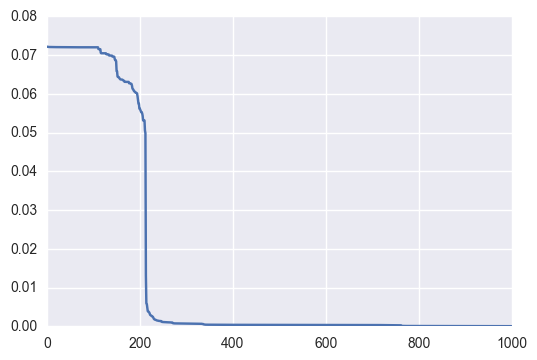

In [116]:
plt.plot(sorted(centrality.values(), reverse=True)[:1000])

$a = \sum_{s,t  \in V}  \frac{d(s,t)}{n(n-1)}$

# Connectedness

Let's take a look at the graph as a whole. One thing I'm not sure of is whether or not the entire graph is connected. This means that any node can be reached from any other node. Since we constructed the graph from 49 unrelated nodes, it is possible that the graph is unconnected. This would mean that one or more of the default subreddits and its subreddits is not connected with the rest of the graph. In searching for the shortest path I did not come across any pairs of nodes that did not have a path between themselves. I wouldn't be surprised if there are a handful of nodes that stand on their own. 

In [136]:
#size of graph: nodes and edges (or, subreddits and connecting links)
print "Our graph has " + str(nx.number_of_nodes(G1)) + ' nodes and ' + str(nx.number_of_edges(G1)) + ' edges.' 

Our graph has 29854 nodes and 149491 edges.


In [140]:
print "True of False: our graph is connected... " + str(nx.is_connected(G1)) + '!'

True of False: our graph is connected... False!


In [156]:
Gc = max(nx.connected_component_subgraphs(G1), key=len)
print "The largest connected component subgraph has " + str(nx.number_of_nodes(Gc)) + " nodes. " 

The largest connected component subgraph has 29840 nodes. 


There are 14 nodes that are not connected to the main connected component. Let's list them. 

In [166]:
for x in list(set(nx.to_dict_of_lists(G1, nodelist=None).keys()) - set(nx.to_dict_of_lists(Gc, nodelist=None).keys())): print x, 

/r/spacediscussions /r/wtfit.gif /r/space. /r/subreddit_graph /r/vidalia /r/listentothis. /r/history. /r/all. /r/ghostdriver /r/personalfinance. /r/toombscounty /r/gaming /r/science /r/books.


Some of the large communities on reddit include /r/books, /r/gaming and /r/science. These subreddits list related subreddits on separate wiki pages since there are many related subreddits for each one. They were most likely all captured in the subsequent levels of the graph, but they also did not link back to /r/science. Here's an example: 

In [172]:
for x in master_df_u.loc[master_df_u.subreddit=='/r/physics'].related: print x

['/r/physicsjokes', '/r/gradadmissions', '/r/homeworkhelp', '/r/scienceimages', '/r/askacademia', '/r/physicsgifs', '/r/physicsstudents', '/r/gradschool', '/r/askphysics', '/r/physics']


To be continued...